In [1]:
!pip install spektral -q

import numpy as np
import matplotlib.pyplot as plt
import sys, gc, os
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from spektral.data import DisjointLoader
from spektral.transforms.normalize_adj import NormalizeAdj

# to import data from drive
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/GraphoVerse/')

from graph import VIPERSGraph, VIPERSGraphPhoto, VIPERSGraphHav, VIPERSOriginal
from models import NezNet, DenseNet
from utils import z_metrics, best_scores, find_thres, cat_max_id, VIP_norm, plot_results, plot_roc
from train import train_model, test_model

W1 = '/content/drive/MyDrive/GraphoVerse/W1_PHOT-SPEC_MATCH_PDR.txt'  # training and validation
W4 = '/content/drive/MyDrive/GraphoVerse/W4_PHOT-SPEC_MATCH_PDR.txt'  # testing

# to re-upload stuff
#import importlib
#importlib.reload(graph)

     |████████████████████████████████| 140 kB 7.1 MB/s 
Mounted at /content/drive


In [4]:
def main(modelout, n_nbrs, Dz, build_graph, batch_size = 32, learning_rate = 1e-03, patience=10, size_tr = 15000, size_te = 10000, prefix='', foldernet='/content/drive/MyDrive/GraphoVerse/NezNet'):
    ''' function to train and test NezNet model. It automatically saves the weights.
    Inputs::
      n_nbrs: number of neighbours. Note: the effective number of neighbours is n_nbrs-1
      Dz: redshift seperation to define real neighbours
      build_graph: data structure to build the graph. Available structures in graph.py are [VIPERSGraph, VIPERSGraphPhoto, VIPERSGraphHav]
      size_tr: number of photometric galaxies for training, each will have n_nbrs-1 neighbours
      size_te: number of photometric galaxies for testing, each will have n_nbrs-1 neighbours
      prefix: string to attach at the beginning of the folder
      foldernet: string with path of output folder, it should exist
     '''
    global W1, W4
    if n_nbrs<=1:
      raise ValueError('n_nbrs should be greater than 1')

    if Dz<=0.0:
      raise ValueError('Dz should be greater than 0.0')
    
    if not os.path.exists(foldernet):
      raise ValueError('foldernet should exist')

    print('considering angular neighbours n_nbrs = ', n_nbrs-1)
    print('Dz to define a spectroscopic neighbour=', Dz)
 
    # fix seeds
    seed_tr = 314
    seed_te = 161
    seed_pm = 271
    
    # all objects
    z_min=0.0
    z_max=6.0

    # create graph dataset
    nids = cat_max_id(W1,z_min,z_max)
    norms = VIP_norm(z_min,z_max) # norm [0,1]
    rng = np.random.default_rng(seed_tr)
    ids = rng.choice(np.arange(nids), size=size_tr, replace=False)
    dataset = build_graph( ids, *norms, n_nbrs=n_nbrs, transforms=NormalizeAdj(), z_min=z_min, z_max=z_max, Dz=Dz, filedata = W1 )
   
    # train/valid split
    rng = np.random.default_rng(seed_pm)
    idxs = rng.permutation(len(dataset))
    reorder = np.argsort(idxs)
    split_va = int(0.75 * len(dataset))
    idx_tr, idx_va = np.split(idxs, [split_va])
    data_tr = dataset[idx_tr]
    data_va = dataset[idx_va]
    
    # Data loaders
    loader_tr = DisjointLoader(data_tr, batch_size=batch_size)
    loader_va = DisjointLoader(data_va, batch_size=batch_size)   

    # build NezNet
    X = Input(shape=(dataset.n_node_features,))
    A = Input((None,), sparse=True)
    I = Input(shape=(), dtype=tf.int64)
    out   = modelout([X,A,I])
    model = Model(inputs=[X, A, I], outputs=out)

    # train model
    _ = train_model(patience, model, loader_tr, loader_va, learning_rate)

    # Save weights
    foldernet += '/' + prefix + 'bs%d_nt%d_lr%g_nbr%d_Dz%g' % (batch_size, size_tr, learning_rate, n_nbrs-1, Dz)
    foldernet_img = foldernet+'/images'
    print('saving weights in ', foldernet)
    if not os.path.exists(foldernet):
      os.mkdir(foldernet)
      os.mkdir(foldernet_img)
    model.save_weights(foldernet+'/best_weights')

    # load W4 data for testing and build graph
    nids = cat_max_id(W4,z_min,z_max)
    rng = np.random.default_rng(seed_te)
    id_te = rng.choice(np.arange(nids), size=size_te, replace=False)
    data_te4 = build_graph( id_te, *norms, n_nbrs=n_nbrs, transforms=NormalizeAdj(), z_min=z_min, z_max=z_max, Dz=Dz, filedata = W4)

    # predictions
    loader_te4 = DisjointLoader(data_te4, shuffle=False)
    test_results = test_model(model, loader_te4)
    nz, tz, sc, lb = best_scores(test_results,len(id_te), n_nbrs)
    fpr, tpr, auc_roc, fprOpt, tprOpt, thresholdOpt = find_thres(lb, sc)
    
    # plot and metrics
    plot_roc(fpr, tpr, auc_roc, fprOpt, tprOpt, thresholdOpt, folder_img=foldernet_img)
    plot_results(Dz,data_te4, thresholdOpt, [nz, tz, sc, lb], folder_img=foldernet_img)
    return

considering angular neighbours n_nbrs =  1
Dz to define a spectroscopic neighbour= 0.08


/usr/local/lib/python3.7/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'VIPERSGraphPhoto' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch=0
 loss=0.6730	 val_loss=0.6507	 acc=0.532	 val_acc=0.567	 prec=0.469	 val_prec=0.547	 recl=0.184	 val_recl=0.372
Epoch=5
 loss=0.4446	 val_loss=0.4391	 acc=0.693	 val_acc=0.702	 prec=0.669	 val_prec=0.677	 recl=0.670	 val_recl=0.683
Epoch=10
 loss=0.3875	 val_loss=0.3892	 acc=0.751	 val_acc=0.755	 prec=0.723	 val_prec=0.726	 recl=0.751	 val_recl=0.754
Epoch=15
 loss=0.3624	 val_loss=0.3633	 acc=0.778	 val_acc=0.780	 prec=0.749	 val_prec=0.751	 recl=0.784	 val_recl=0.786
Epoch=20
 loss=0.3410	 val_loss=0.3592	 acc=0.794	 val_acc=0.795	 prec=0.764	 val_prec=0.766	 recl=0.802	 val_recl=0.804
Epoch=25
 loss=0.3315	 val_loss=0.3413	 acc=0.805	 val_acc=0.806	 prec=0.776	 val_prec=0.777	 recl=0.816	 val_recl=0.817
Epoch=30
 loss=0.3222	 val_loss=0.3333	 acc=0.814	 val_acc=0.815	 prec=0.784	 val_prec=0.785	 recl=0.825	 val_recl=0.826
Epoch=35
 loss=0.3117	 val_loss=0.3158	 acc=0.821	 val_acc=0.821	 prec=0.791	 val_prec=0.792	 recl=0.832	 val_recl=0.833
Epoch=40
 loss=0.3089	 val_loss=0.

/content/drive/MyDrive/GraphoVerse/train.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.squeeze(np.array(test_results),axis=-1)


Best Threshold: 0.5242 with G-Mean: 0.8604
FPR: 0.1441, TPR: 0.8649


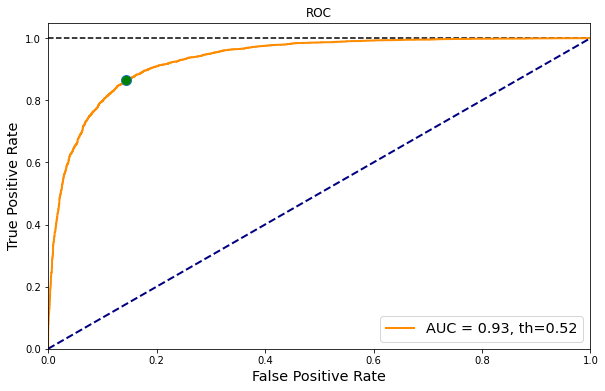

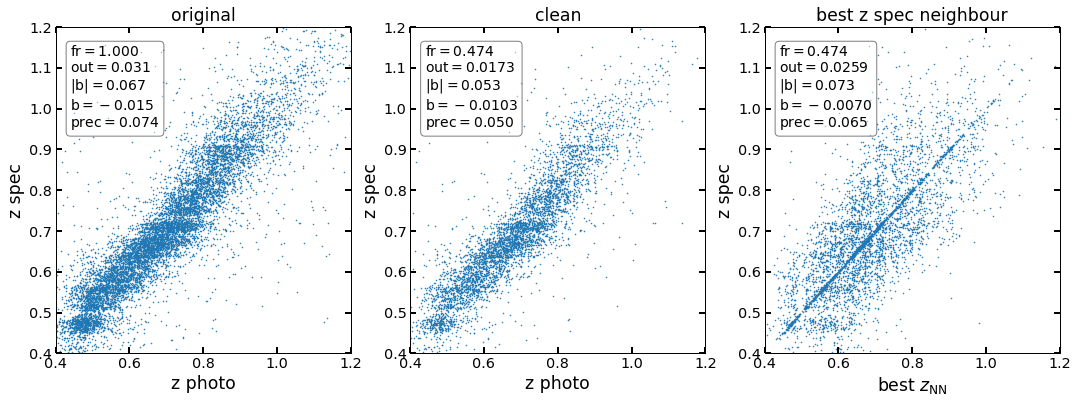

considering angular neighbours n_nbrs =  5
Dz to define a spectroscopic neighbour= 0.08


/usr/local/lib/python3.7/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'VIPERSGraphPhoto' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch=0
 loss=0.5859	 val_loss=0.4888	 acc=0.614	 val_acc=0.684	 prec=0.585	 val_prec=0.658	 recl=0.379	 val_recl=0.600
Epoch=5
 loss=0.3415	 val_loss=0.3309	 acc=0.805	 val_acc=0.809	 prec=0.762	 val_prec=0.766	 recl=0.814	 val_recl=0.819
Epoch=10
 loss=0.3218	 val_loss=0.3191	 acc=0.830	 val_acc=0.831	 prec=0.791	 val_prec=0.793	 recl=0.837	 val_recl=0.839
Epoch=15
 loss=0.3107	 val_loss=0.3332	 acc=0.841	 val_acc=0.842	 prec=0.804	 val_prec=0.805	 recl=0.848	 val_recl=0.848
Epoch=20
 loss=0.3053	 val_loss=0.3115	 acc=0.847	 val_acc=0.847	 prec=0.811	 val_prec=0.812	 recl=0.852	 val_recl=0.853
Epoch=25
 loss=0.3015	 val_loss=0.3017	 acc=0.851	 val_acc=0.851	 prec=0.818	 val_prec=0.818	 recl=0.855	 val_recl=0.855
Epoch=30
 loss=0.2966	 val_loss=0.2923	 acc=0.854	 val_acc=0.854	 prec=0.822	 val_prec=0.823	 recl=0.855	 val_recl=0.856
Epoch=35
 loss=0.2971	 val_loss=0.2977	 acc=0.856	 val_acc=0.857	 prec=0.826	 val_prec=0.826	 recl=0.857	 val_recl=0.857
Epoch=40
 loss=0.2935	 val_loss=0.

/content/drive/MyDrive/GraphoVerse/train.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.squeeze(np.array(test_results),axis=-1)


Best Threshold: 0.8571 with G-Mean: 0.7991
FPR: 0.2225, TPR: 0.8213


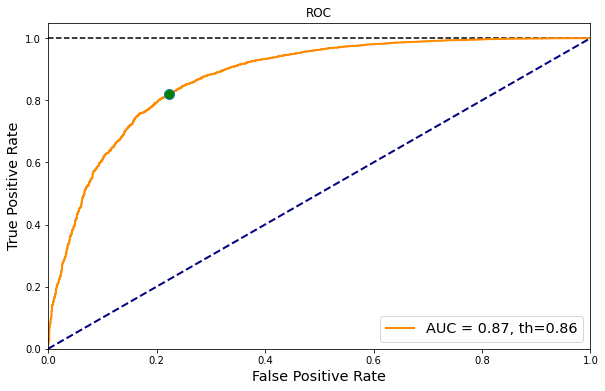

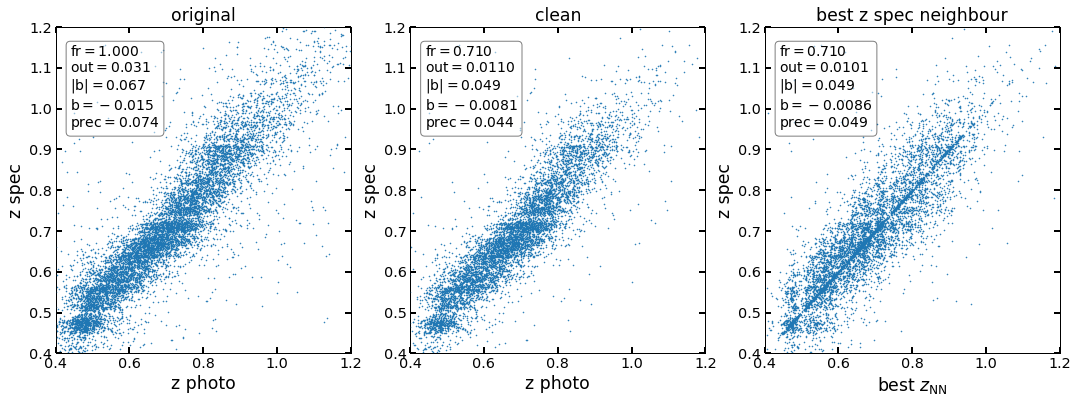

considering angular neighbours n_nbrs =  10
Dz to define a spectroscopic neighbour= 0.08


/usr/local/lib/python3.7/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'VIPERSGraphPhoto' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch=0
 loss=0.4720	 val_loss=0.3564	 acc=0.699	 val_acc=0.777	 prec=0.659	 val_prec=0.744	 recl=0.540	 val_recl=0.739
Epoch=5
 loss=0.3333	 val_loss=0.3316	 acc=0.836	 val_acc=0.838	 prec=0.800	 val_prec=0.801	 recl=0.831	 val_recl=0.833
Epoch=10
 loss=0.3132	 val_loss=0.3210	 acc=0.848	 val_acc=0.849	 prec=0.813	 val_prec=0.814	 recl=0.843	 val_recl=0.844
Epoch=15
 loss=0.3037	 val_loss=0.2943	 acc=0.854	 val_acc=0.855	 prec=0.821	 val_prec=0.822	 recl=0.848	 val_recl=0.849
Epoch=20
 loss=0.2995	 val_loss=0.2920	 acc=0.858	 val_acc=0.858	 prec=0.825	 val_prec=0.826	 recl=0.852	 val_recl=0.853
Epoch=25
 loss=0.2961	 val_loss=0.3020	 acc=0.861	 val_acc=0.861	 prec=0.829	 val_prec=0.829	 recl=0.855	 val_recl=0.855
Epoch=30
 loss=0.2938	 val_loss=0.2955	 acc=0.863	 val_acc=0.863	 prec=0.831	 val_prec=0.832	 recl=0.857	 val_recl=0.857
Epoch=35
 loss=0.2911	 val_loss=0.2952	 acc=0.864	 val_acc=0.864	 prec=0.833	 val_prec=0.833	 recl=0.859	 val_recl=0.859
Early stopping (best val_loss: 0.2

/content/drive/MyDrive/GraphoVerse/train.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.squeeze(np.array(test_results),axis=-1)


Best Threshold: 0.9039 with G-Mean: 0.7616
FPR: 0.291, TPR: 0.8181


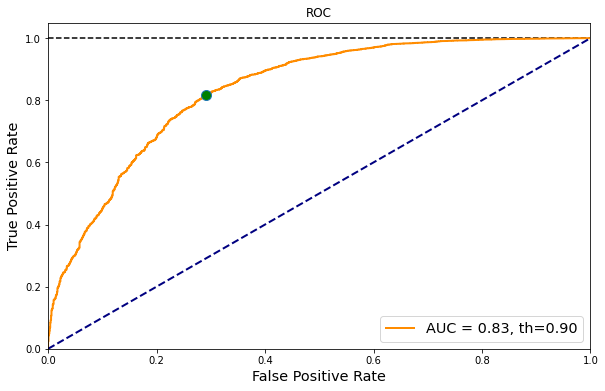

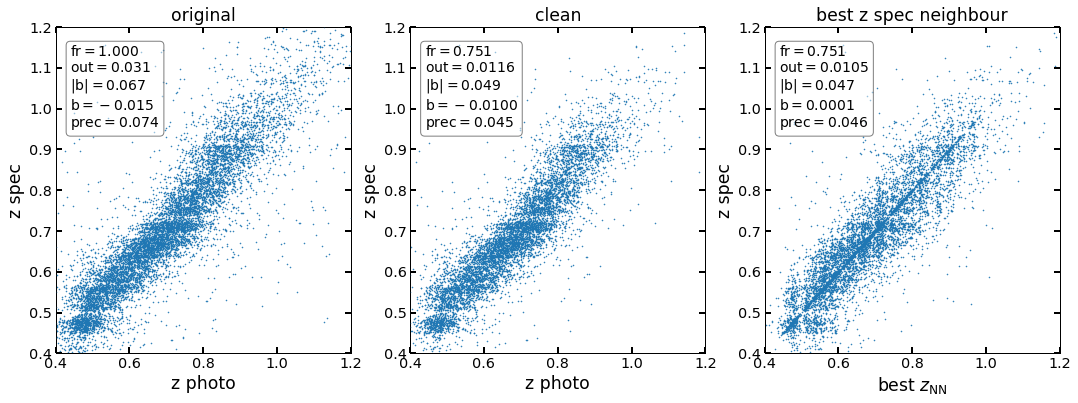

considering angular neighbours n_nbrs =  30
Dz to define a spectroscopic neighbour= 0.08


/usr/local/lib/python3.7/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'VIPERSGraphPhoto' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch=0
 loss=0.3893	 val_loss=0.3423	 acc=0.769	 val_acc=0.824	 prec=0.736	 val_prec=0.786	 recl=0.687	 val_recl=0.806
Epoch=5
 loss=0.3045	 val_loss=0.3106	 acc=0.855	 val_acc=0.856	 prec=0.824	 val_prec=0.824	 recl=0.841	 val_recl=0.843
Epoch=10
 loss=0.2924	 val_loss=0.2819	 acc=0.863	 val_acc=0.863	 prec=0.832	 val_prec=0.832	 recl=0.850	 val_recl=0.850
Epoch=15
 loss=0.2861	 val_loss=0.2866	 acc=0.867	 val_acc=0.867	 prec=0.837	 val_prec=0.837	 recl=0.853	 val_recl=0.854
Epoch=20
 loss=0.2829	 val_loss=0.2761	 acc=0.869	 val_acc=0.869	 prec=0.840	 val_prec=0.841	 recl=0.855	 val_recl=0.856
Epoch=25
 loss=0.2795	 val_loss=0.2782	 acc=0.871	 val_acc=0.871	 prec=0.843	 val_prec=0.843	 recl=0.857	 val_recl=0.857
Epoch=30
 loss=0.2774	 val_loss=0.2735	 acc=0.872	 val_acc=0.872	 prec=0.844	 val_prec=0.845	 recl=0.858	 val_recl=0.858
Epoch=35
 loss=0.2756	 val_loss=0.2703	 acc=0.873	 val_acc=0.873	 prec=0.846	 val_prec=0.846	 recl=0.860	 val_recl=0.860
Epoch=40
 loss=0.2732	 val_loss=0.

/content/drive/MyDrive/GraphoVerse/train.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.squeeze(np.array(test_results),axis=-1)


Best Threshold: 0.94 with G-Mean: 0.7544
FPR: 0.3003, TPR: 0.8134


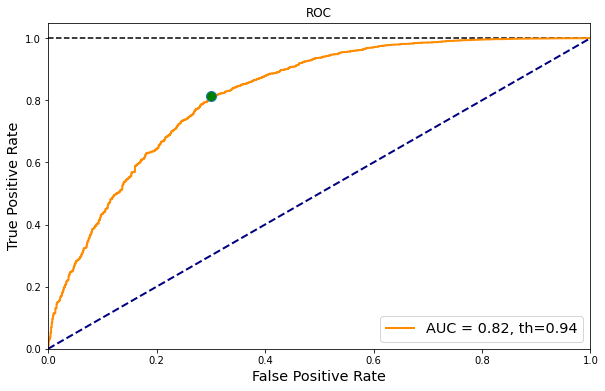

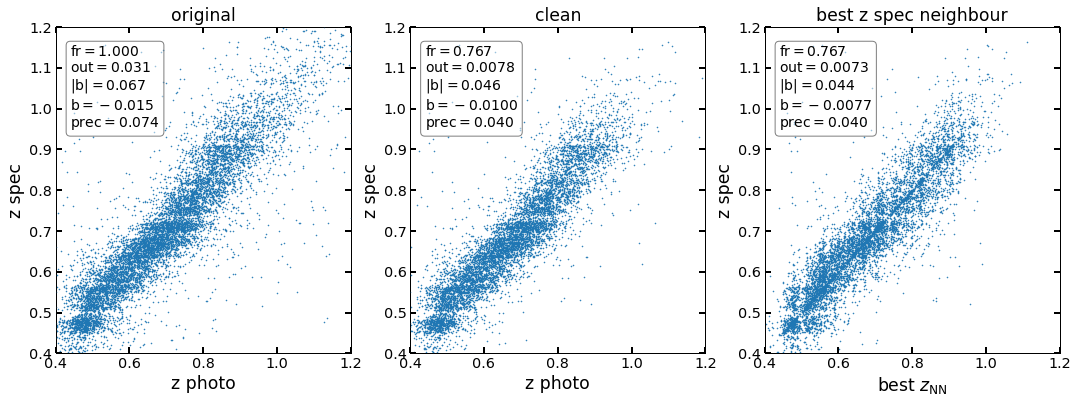

In [16]:
# fix Dz, change n_nbrs

modelout = NezNet(hidden_pre=32, hidden_cn=32, hidden_post=32, n_pre=1, n_post=1, act="relu", bn=False)
main(modelout, 2, 0.08,  VIPERSGraphPhoto)

modelout = NezNet(hidden_pre=32, hidden_cn=32, hidden_post=32, n_pre=1, n_post=1, act="relu", bn=False)
main(modelout, 6, 0.08,  VIPERSGraphPhoto)

modelout = NezNet(hidden_pre=32, hidden_cn=32, hidden_post=32, n_pre=1, n_post=1, act="relu", bn=False )
main(modelout, 11, 0.08, VIPERSGraphPhoto)

modelout = NezNet(hidden_pre=32, hidden_cn=32, hidden_post=32, n_pre=1, n_post=1, act="relu", bn=False )
main(modelout, 31, 0.08, VIPERSGraphPhoto)

considering angular neighbours n_nbrs =  30
Dz to define a spectroscopic neighbour= 0.02


/usr/local/lib/python3.7/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'VIPERSGraphPhoto' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch=0
 loss=0.3080	 val_loss=0.2670	 acc=0.864	 val_acc=0.865	 prec=0.341	 val_prec=0.536	 recl=0.021	 val_recl=0.091
Epoch=5
 loss=0.2591	 val_loss=0.2741	 acc=0.872	 val_acc=0.872	 prec=0.566	 val_prec=0.566	 recl=0.258	 val_recl=0.261
Epoch=10
 loss=0.2526	 val_loss=0.2462	 acc=0.874	 val_acc=0.874	 prec=0.571	 val_prec=0.571	 recl=0.302	 val_recl=0.307
Epoch=15
 loss=0.2491	 val_loss=0.2574	 acc=0.875	 val_acc=0.875	 prec=0.576	 val_prec=0.576	 recl=0.329	 val_recl=0.330
Epoch=20
 loss=0.2476	 val_loss=0.2387	 acc=0.876	 val_acc=0.877	 prec=0.580	 val_prec=0.580	 recl=0.343	 val_recl=0.344
Epoch=25
 loss=0.2455	 val_loss=0.2549	 acc=0.877	 val_acc=0.877	 prec=0.583	 val_prec=0.584	 recl=0.350	 val_recl=0.351
Epoch=30
 loss=0.2441	 val_loss=0.2427	 acc=0.878	 val_acc=0.878	 prec=0.585	 val_prec=0.586	 recl=0.359	 val_recl=0.359
Early stopping (best val_loss: 0.23854892099418162)
saving weights in  /content/drive/MyDrive/GraphoVerse/NezNet/bs32_nt15000_lr0.001_nbr30_Dz0.02


/content/drive/MyDrive/GraphoVerse/train.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.squeeze(np.array(test_results),axis=-1)


Best Threshold: 0.5239 with G-Mean: 0.6053
FPR: 0.401, TPR: 0.6116


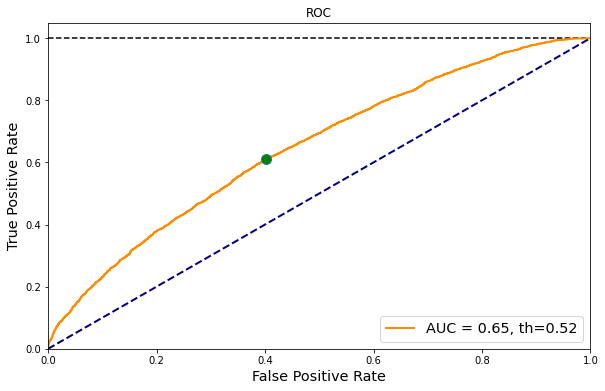

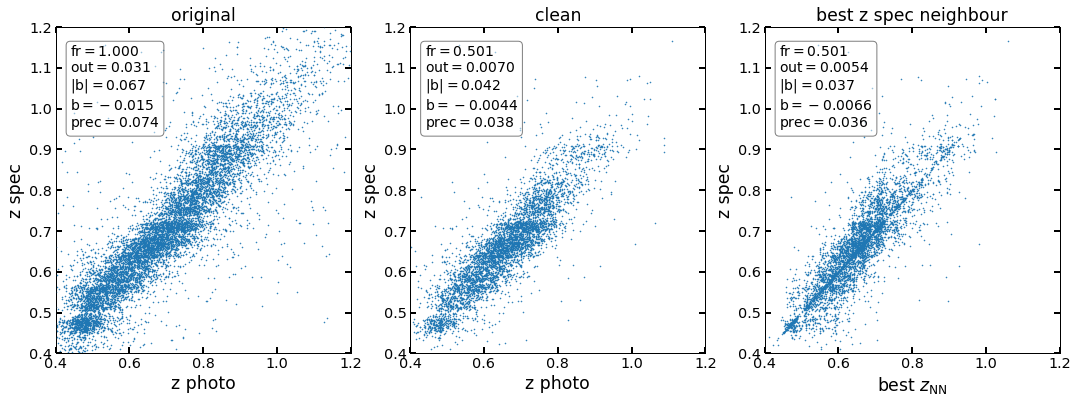

considering angular neighbours n_nbrs =  30
Dz to define a spectroscopic neighbour= 0.04


/usr/local/lib/python3.7/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'VIPERSGraphPhoto' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch=0
 loss=0.3793	 val_loss=0.3251	 acc=0.790	 val_acc=0.820	 prec=0.543	 val_prec=0.652	 recl=0.268	 val_recl=0.510
Epoch=5
 loss=0.2989	 val_loss=0.2888	 acc=0.850	 val_acc=0.851	 prec=0.695	 val_prec=0.696	 recl=0.652	 val_recl=0.657
Epoch=10
 loss=0.2907	 val_loss=0.2928	 acc=0.857	 val_acc=0.858	 prec=0.705	 val_prec=0.706	 recl=0.682	 val_recl=0.683
Epoch=15
 loss=0.2866	 val_loss=0.2830	 acc=0.861	 val_acc=0.861	 prec=0.710	 val_prec=0.711	 recl=0.694	 val_recl=0.695
Epoch=20
 loss=0.2837	 val_loss=0.2838	 acc=0.863	 val_acc=0.863	 prec=0.714	 val_prec=0.714	 recl=0.700	 val_recl=0.701
Epoch=25
 loss=0.2821	 val_loss=0.2848	 acc=0.864	 val_acc=0.864	 prec=0.717	 val_prec=0.717	 recl=0.705	 val_recl=0.705
Epoch=30
 loss=0.2801	 val_loss=0.2837	 acc=0.865	 val_acc=0.865	 prec=0.719	 val_prec=0.719	 recl=0.707	 val_recl=0.707
Epoch=35
 loss=0.2788	 val_loss=0.2776	 acc=0.866	 val_acc=0.866	 prec=0.721	 val_prec=0.721	 recl=0.710	 val_recl=0.710
Epoch=40
 loss=0.2770	 val_loss=0.

/content/drive/MyDrive/GraphoVerse/train.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.squeeze(np.array(test_results),axis=-1)


Best Threshold: 0.806 with G-Mean: 0.653
FPR: 0.3707, TPR: 0.6775


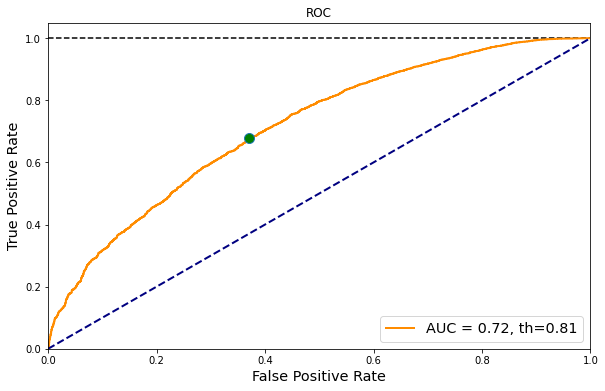

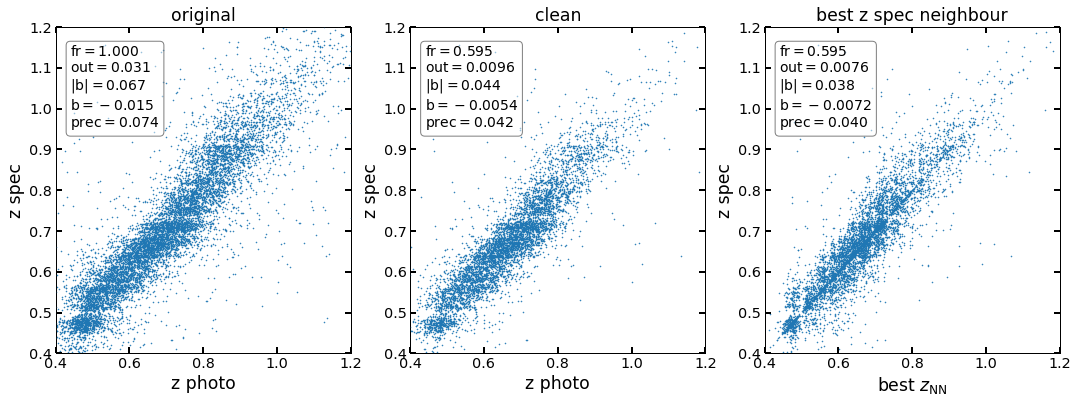

considering angular neighbours n_nbrs =  30
Dz to define a spectroscopic neighbour= 0.15


/usr/local/lib/python3.7/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'VIPERSGraphPhoto' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch=0
 loss=0.3191	 val_loss=0.2638	 acc=0.830	 val_acc=0.868	 prec=0.837	 val_prec=0.881	 recl=0.940	 val_recl=0.934
Epoch=5
 loss=0.2435	 val_loss=0.2496	 acc=0.889	 val_acc=0.890	 prec=0.908	 val_prec=0.909	 recl=0.934	 val_recl=0.934
Epoch=10
 loss=0.2318	 val_loss=0.2295	 acc=0.895	 val_acc=0.895	 prec=0.912	 val_prec=0.913	 recl=0.937	 val_recl=0.937
Epoch=15
 loss=0.2249	 val_loss=0.2273	 acc=0.898	 val_acc=0.898	 prec=0.915	 val_prec=0.916	 recl=0.938	 val_recl=0.938
Epoch=20
 loss=0.2209	 val_loss=0.2189	 acc=0.900	 val_acc=0.900	 prec=0.918	 val_prec=0.918	 recl=0.938	 val_recl=0.939
Early stopping (best val_loss: 0.21843329226053548)
saving weights in  /content/drive/MyDrive/GraphoVerse/NezNet/bs32_nt15000_lr0.001_nbr30_Dz0.15


/content/drive/MyDrive/GraphoVerse/train.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.squeeze(np.array(test_results),axis=-1)


Best Threshold: 0.9828 with G-Mean: 0.7999
FPR: 0.2396, TPR: 0.8415


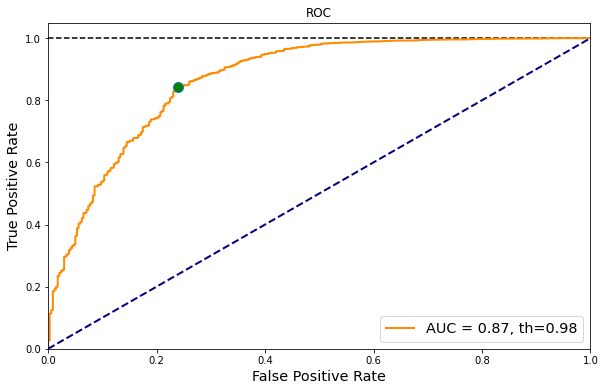

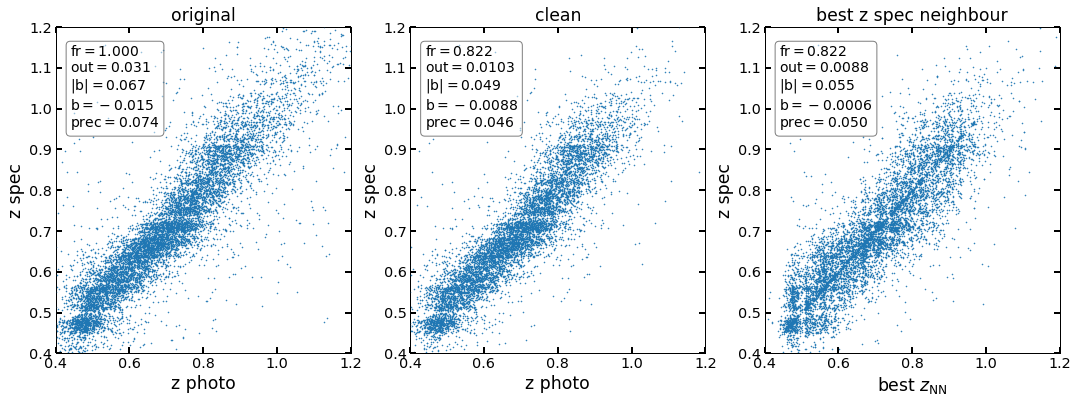

In [17]:
# fixed n_nbrs, changing Dz
modelout = NezNet(hidden_pre=32, hidden_cn=32, hidden_post=32, n_pre=1, n_post=1, act="relu", bn=False)
main(modelout, 31, 0.02, VIPERSGraphPhoto)

modelout = NezNet(hidden_pre=32, hidden_cn=32, hidden_post=32, n_pre=1, n_post=1, act="relu", bn=False)
main(modelout, 31, 0.04, VIPERSGraphPhoto)

modelout = NezNet(hidden_pre=32, hidden_cn=32, hidden_post=32, n_pre=1, n_post=1, act="relu", bn=False)
main(modelout, 31, 0.15, VIPERSGraphPhoto)

considering angular neighbours n_nbrs =  30
Dz to define a spectroscopic neighbour= 0.08


/usr/local/lib/python3.7/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'VIPERSGraphHav' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch=0
 loss=0.3845	 val_loss=0.3423	 acc=0.775	 val_acc=0.827	 prec=0.742	 val_prec=0.787	 recl=0.695	 val_recl=0.815
Epoch=5
 loss=0.3029	 val_loss=0.2958	 acc=0.858	 val_acc=0.859	 prec=0.824	 val_prec=0.825	 recl=0.850	 val_recl=0.850
Epoch=10
 loss=0.2941	 val_loss=0.2979	 acc=0.865	 val_acc=0.865	 prec=0.831	 val_prec=0.832	 recl=0.856	 val_recl=0.856
Epoch=15
 loss=0.2873	 val_loss=0.2782	 acc=0.867	 val_acc=0.868	 prec=0.836	 val_prec=0.836	 recl=0.857	 val_recl=0.857
Epoch=20
 loss=0.2823	 val_loss=0.2906	 acc=0.870	 val_acc=0.870	 prec=0.839	 val_prec=0.839	 recl=0.859	 val_recl=0.859
Epoch=25
 loss=0.2794	 val_loss=0.2797	 acc=0.871	 val_acc=0.871	 prec=0.841	 val_prec=0.842	 recl=0.860	 val_recl=0.860
Early stopping (best val_loss: 0.27394390578007705)
saving weights in  /content/drive/MyDrive/GraphoVerse/NezNet/hav_bs32_nt15000_lr0.001_nbr30_Dz0.08


/content/drive/MyDrive/GraphoVerse/train.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.squeeze(np.array(test_results),axis=-1)


Best Threshold: 0.9413 with G-Mean: 0.7395
FPR: 0.3068, TPR: 0.7889


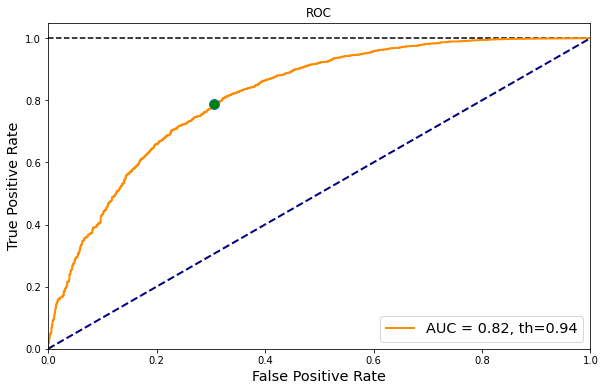

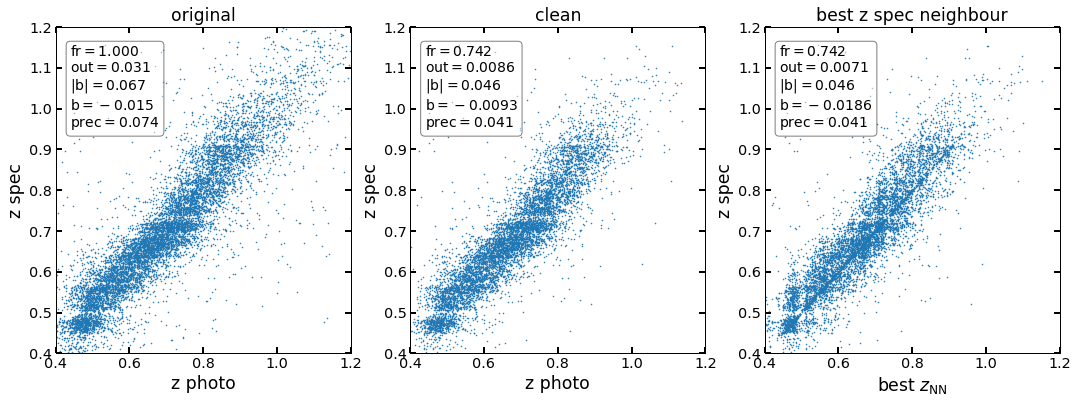

considering angular neighbours n_nbrs =  30
Dz to define a spectroscopic neighbour= 0.08


/usr/local/lib/python3.7/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'VIPERSGraph' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch=0
 loss=0.3920	 val_loss=0.3380	 acc=0.759	 val_acc=0.822	 prec=0.720	 val_prec=0.788	 recl=0.652	 val_recl=0.796
Epoch=5
 loss=0.3047	 val_loss=0.2914	 acc=0.854	 val_acc=0.855	 prec=0.822	 val_prec=0.823	 recl=0.839	 val_recl=0.841
Epoch=10
 loss=0.2942	 val_loss=0.2925	 acc=0.862	 val_acc=0.863	 prec=0.830	 val_prec=0.831	 recl=0.851	 val_recl=0.851
Epoch=15
 loss=0.2888	 val_loss=0.2878	 acc=0.866	 val_acc=0.866	 prec=0.835	 val_prec=0.835	 recl=0.855	 val_recl=0.855
Epoch=20
 loss=0.2848	 val_loss=0.2823	 acc=0.868	 val_acc=0.869	 prec=0.837	 val_prec=0.838	 recl=0.858	 val_recl=0.858
Early stopping (best val_loss: 0.27754291660227604)
saving weights in  /content/drive/MyDrive/GraphoVerse/NezNet/radec_bs32_nt15000_lr0.001_nbr30_Dz0.08


In [ ]:
# changing graph, adding isotropic angle
modelout = NezNet(hidden_pre=32, hidden_cn=32, hidden_post=32, n_pre=1, n_post=1, act="relu", bn=False)
main(modelout, 31, 0.08, VIPERSGraphHav, prefix='hav_')

## changing graph, adding anisotropic angles
#modelout = NezNet(hidden_pre=32, hidden_cn=32, hidden_post=32, n_pre=1, n_post=1, act="relu", bn=False)
#main(modelout, 31, 0.08, VIPERSGraph, prefix='radec_')

considering angular neighbours n_nbrs =  30
Dz to define a spectroscopic neighbour= 0.08


/usr/local/lib/python3.7/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'VIPERSGraph' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch=0
 loss=0.3955	 val_loss=0.3541	 acc=0.767	 val_acc=0.820	 prec=0.725	 val_prec=0.777	 recl=0.694	 val_recl=0.809
Epoch=5
 loss=0.3032	 val_loss=0.2999	 acc=0.855	 val_acc=0.856	 prec=0.820	 val_prec=0.821	 recl=0.845	 val_recl=0.847
Epoch=10
 loss=0.2944	 val_loss=0.2851	 acc=0.862	 val_acc=0.863	 prec=0.831	 val_prec=0.832	 recl=0.850	 val_recl=0.850
Epoch=15
 loss=0.2881	 val_loss=0.2854	 acc=0.866	 val_acc=0.866	 prec=0.836	 val_prec=0.837	 recl=0.853	 val_recl=0.853
Epoch=20
 loss=0.2842	 val_loss=0.2898	 acc=0.869	 val_acc=0.869	 prec=0.839	 val_prec=0.840	 recl=0.855	 val_recl=0.855
Epoch=25
 loss=0.2811	 val_loss=0.2769	 acc=0.870	 val_acc=0.870	 prec=0.842	 val_prec=0.842	 recl=0.857	 val_recl=0.857
Epoch=30
 loss=0.2794	 val_loss=0.2736	 acc=0.871	 val_acc=0.872	 prec=0.843	 val_prec=0.843	 recl=0.858	 val_recl=0.858
Epoch=35
 loss=0.2770	 val_loss=0.2729	 acc=0.873	 val_acc=0.873	 prec=0.845	 val_prec=0.845	 recl=0.859	 val_recl=0.859
Epoch=40
 loss=0.2748	 val_loss=0.

/content/drive/MyDrive/GraphoVerse/train.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.squeeze(np.array(test_results),axis=-1)


Best Threshold: 0.95 with G-Mean: 0.7468
FPR: 0.2552, TPR: 0.7489


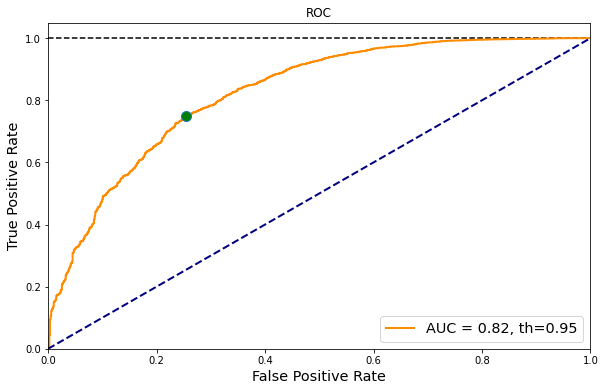

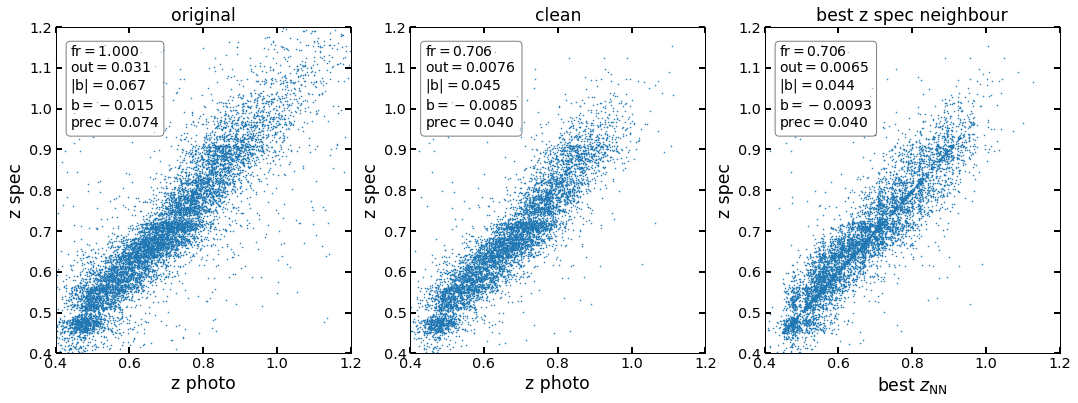

In [4]:
# changing graph, adding anisotropic angles
modelout = NezNet(hidden_pre=32, hidden_cn=32, hidden_post=32, n_pre=1, n_post=1, act="relu", bn=False)
main(modelout, 31, 0.08, VIPERSGraph, prefix='radec_')

In [17]:
# to re-upload stuff
import importlib
import models
importlib.reload(models)
import models
from models import DenseNet

considering angular neighbours n_nbrs =  30
Dz to define a spectroscopic neighbour= 0.08


/usr/local/lib/python3.7/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'VIPERSGraphPhoto' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch=0
 loss=0.4369	 val_loss=0.3572	 acc=0.710	 val_acc=0.793	 prec=0.681	 val_prec=0.759	 recl=0.550	 val_recl=0.755
Epoch=5
 loss=0.3140	 val_loss=0.3012	 acc=0.843	 val_acc=0.845	 prec=0.806	 val_prec=0.808	 recl=0.832	 val_recl=0.835
Epoch=10
 loss=0.3021	 val_loss=0.3017	 acc=0.855	 val_acc=0.855	 prec=0.820	 val_prec=0.821	 recl=0.845	 val_recl=0.845
Epoch=15
 loss=0.2969	 val_loss=0.2846	 acc=0.860	 val_acc=0.860	 prec=0.826	 val_prec=0.826	 recl=0.851	 val_recl=0.851
Epoch=20
 loss=0.2930	 val_loss=0.2927	 acc=0.863	 val_acc=0.863	 prec=0.830	 val_prec=0.830	 recl=0.854	 val_recl=0.854
Epoch=25
 loss=0.2896	 val_loss=0.2822	 acc=0.865	 val_acc=0.865	 prec=0.832	 val_prec=0.832	 recl=0.856	 val_recl=0.856
Epoch=30
 loss=0.2861	 val_loss=0.2794	 acc=0.867	 val_acc=0.867	 prec=0.835	 val_prec=0.835	 recl=0.857	 val_recl=0.857
Epoch=35
 loss=0.2844	 val_loss=0.2752	 acc=0.868	 val_acc=0.868	 prec=0.836	 val_prec=0.836	 recl=0.859	 val_recl=0.859
Epoch=40
 loss=0.2818	 val_loss=0.

/content/drive/MyDrive/GraphoVerse/train.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.squeeze(np.array(test_results),axis=-1)


Best Threshold: 0.9439 with G-Mean: 0.7495
FPR: 0.2611, TPR: 0.7602


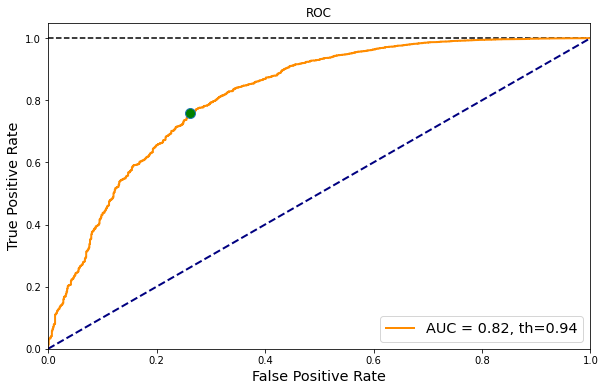

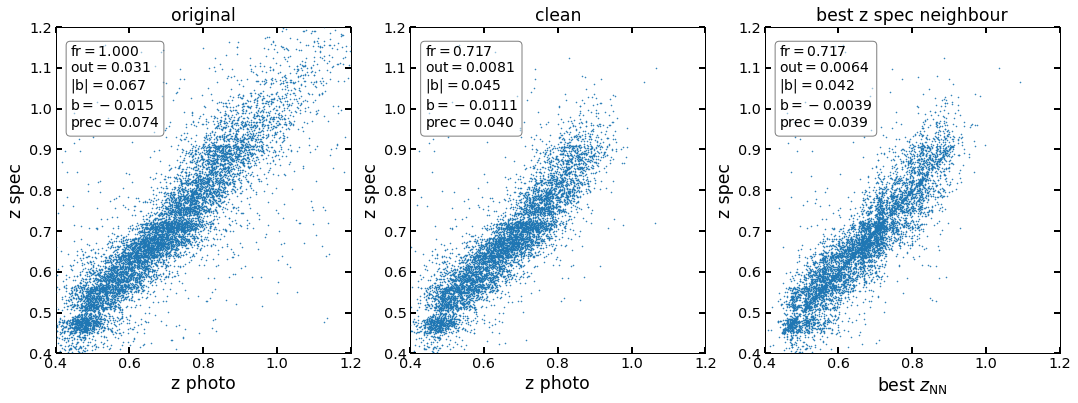

In [18]:
# changing model
modelout = DenseNet(hidden_pre=32, hidden_post=32, n_pre=2, n_post=1, act="relu", bn=False)
main(modelout, 31, 0.08, VIPERSGraphPhoto, prefix='dense_')